In [1]:
import rosbag
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

sns.set_style('darkgrid')
%matplotlib inline

In [2]:
# Load rosbag
bag_path = '/workspace/rosbags/2025-12-17-16-02-22.bag'
bag = rosbag.Bag(bag_path)

# Get bag info
print(f"Bag: {bag_path}")
print(f"Duration: {bag.get_end_time() - bag.get_start_time():.2f} seconds")
print(f"\nTopics:")
for topic, topic_info in bag.get_type_and_topic_info().topics.items():
    print(f"  {topic}: {topic_info.message_count} messages ({topic_info.msg_type})")

Bag: /workspace/rosbags/2025-12-17-16-02-22.bag
Duration: 48.59 seconds

Topics:
  /angrybird2/active_reference/markers: 9237 messages (visualization_msgs/Marker)
  /angrybird2/active_reference/path: 9243 messages (nav_msgs/Path)
  /angrybird2/agiros_pilot/mpc_command: 14609 messages (agiros_msgs/Command)
  /angrybird2/agiros_pilot/odometry: 14688 messages (nav_msgs/Odometry)
  /angrybird2/agiros_pilot/state: 14674 messages (agiros_msgs/QuadState)
  /angrybird2/agiros_pilot/telemetry: 14641 messages (agiros_msgs/Telemetry)
  /angrybird2/control_mode: 48462 messages (agiros_msgs/UInt8Stamped)
  /angrybird2/imu: 48437 messages (sensor_msgs/Imu)
  /angrybird2/outer_setpoints/markers: 9237 messages (visualization_msgs/Marker)
  /angrybird2/outer_setpoints/path: 9244 messages (nav_msgs/Path)
  /angrybird2/references/markers: 31 messages (visualization_msgs/Marker)
  /angrybird2/references/path: 49 messages (nav_msgs/Path)
  /angrybird2/rotor_feedback: 48228 messages (agiros_msgs/RotorFeedba

## Data Sources and Quality Notes

### Raw MoCap Data
- `/mocap/angrybird2/pose`: Pure Vicon data
- `/mocap/angrybird2/accel`: Contains jumps in position data

### State Estimation (Kalman smoothed MoCap data)
- `/angrybird2/agiros_pilot/state`: Better quality, higher resolution
- `/angrybird2/agiros_pilot/odometry`: Lower quality

### IMU Data
- `/angrybird2/imu`: Raw IMU data from Pixhawk

### Radar Data
- `/ti_mmwave/radar_scan`: Raw radar scan data
- `/ti_mmwave/radar_scan_pcl_0`: Radar point cloud (PointCloud2 format)
- `/mmWaveDataHdl/RScanVelocity`: Radar velocity data

### Original Notes
- kalman mocap ist: odometry is schlecht, state ist besser höhere auflösung.
- imu sind raw imu pixhawk daten
- mocap angrybird2 ist reine vicon. mocap angrybird accel has jumps in its position

In [3]:
# Extract timestamps from each sensor
timestamps = defaultdict(list)

# Adjust these topic names based on your actual rosbag
topics_to_analyze = [
    '/ti_mmwave/radar_scan',  # Radar
    # '/mocap/pose',           # MoCap (adjust name)
    # '/imu/data',             # IMU (adjust name)
]

for topic, msg, t in bag.read_messages(topics=topics_to_analyze):
    # Store both ROS time (t) and message header time if available
    if hasattr(msg, 'header'):
        timestamps[topic].append({
            'ros_time': t.to_sec(),
            'msg_time': msg.header.stamp.to_sec()
        })
    else:
        timestamps[topic].append({
            'ros_time': t.to_sec(),
            'msg_time': t.to_sec()
        })

bag.close()

# Convert to DataFrames
dfs = {}
for topic, data in timestamps.items():
    df = pd.DataFrame(data)
    df['delay'] = df['ros_time'] - df['msg_time']
    dfs[topic] = df
    print(f"\n{topic}:")
    print(f"  Messages: {len(df)}")
    print(f"  Avg delay: {df['delay'].mean()*1000:.2f} ms")
    print(f"  Std delay: {df['delay'].std()*1000:.2f} ms")


/ti_mmwave/radar_scan:
  Messages: 6689
  Avg delay: 3.53 ms
  Std delay: 40.70 ms


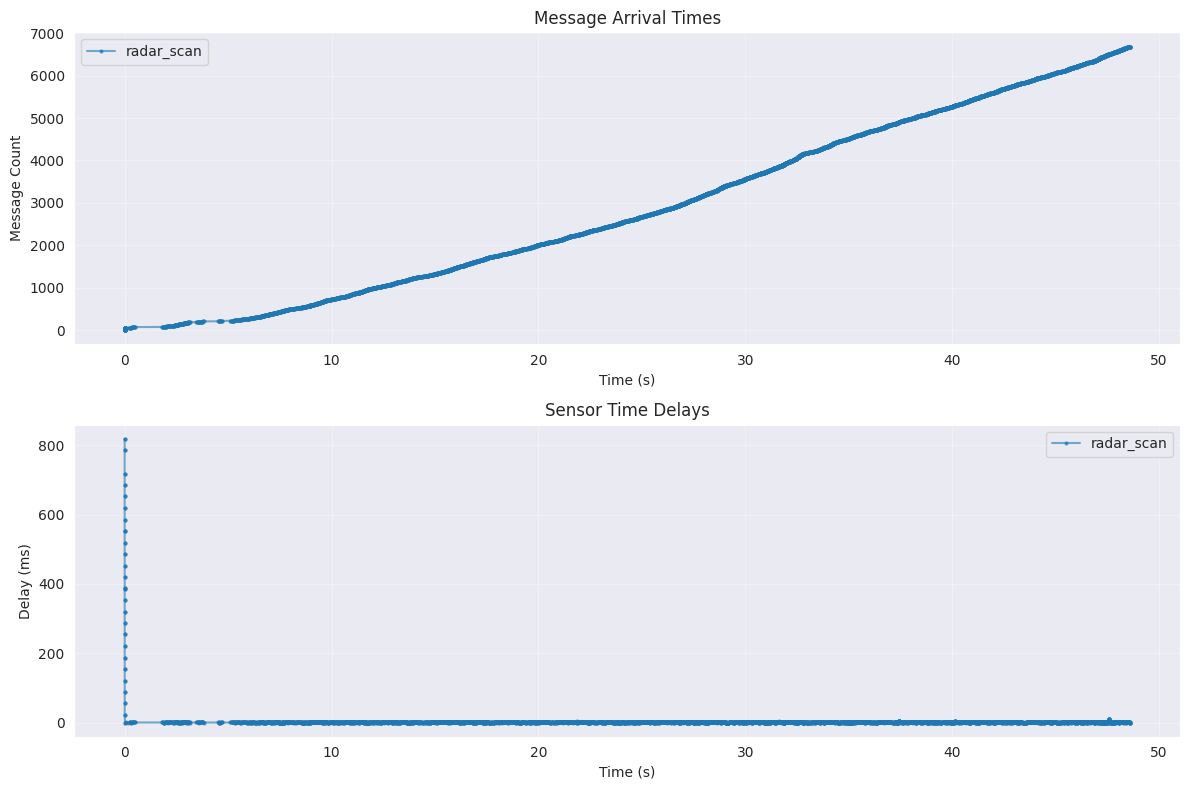

In [4]:
# Plot timestamps and delays
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Plot 1: Message frequency over time
ax = axes[0]
for topic, df in dfs.items():
    ax.plot(df['ros_time'] - df['ros_time'].min(), 
            np.arange(len(df)), 
            label=topic.split('/')[-1], 
            marker='o', markersize=2, alpha=0.6)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Message Count')
ax.set_title('Message Arrival Times')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Time delays
ax = axes[1]
for topic, df in dfs.items():
    ax.plot(df['ros_time'] - df['ros_time'].min(), 
            df['delay'] * 1000,  # Convert to ms
            label=topic.split('/')[-1], 
            marker='o', markersize=2, alpha=0.6)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Delay (ms)')
ax.set_title('Sensor Time Delays')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [5]:
# Analyze radar data in detail
bag = rosbag.Bag(bag_path)
radar_data = []

for topic, msg, t in bag.read_messages(topics=['/ti_mmwave/radar_scan']):
    radar_data.append({
        'time': t.to_sec(),
        'num_points': len(msg.point_id) if hasattr(msg, 'point_id') else 0,
        # Add more fields based on your radar message structure
    })

bag.close()

radar_df = pd.DataFrame(radar_data)
print(f"Radar statistics:")
print(radar_df.describe())

TypeError: object of type 'int' has no len()

## Next Steps

1. Adjust topic names to match your rosbag
2. Extract relevant data from each sensor type
3. Compute cross-correlation for time delay estimation
4. Visualize motion trajectories